In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import datetime as dt
import pickle
import os

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install dgl

     |████████████████████████████████| 3.6MB 14.3MB/s 


In [ ]:
!pip install --pre dgl-cu101

     |████████████████████████████████| 20.9MB 1.3MB/s 


In [ ]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [ ]:
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [ ]:
class GCNLSTM(nn.Module):
    def __init__(self, n_feats, seq_len):
        super(GCNLSTM, self).__init__()
        self.n_feats = n_feats
        self.seq_len = seq_len
        self.n_hidden = 6 # number of hidden states for LSTM cell
        self.n_layers = 5 # number of stacked LSTM layers, original 3, new 5

        self.lstm = nn.LSTM(input_size=n_feats,
                            hidden_size=self.n_hidden,
                            num_layers=self.n_layers,
                            batch_first=True,
                            # bidirectional=True,
                    dropout=0.3)
    
    def forward(self, g, feature):
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.lstm(h)[0]

In [ ]:
class GCNLinear(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLinear, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)


In [ ]:
class GCNConv(nn.Module):
    def __init__(self, btch_size,seq_len,in_feats,out_feats):
        super(GCNConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_feats,kernel_size=(5,5))

    def forward(self, g, feature):
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.conv(h)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # self.layer0 = GCNConv(124,6,1,20)
        self.layer1 = GCNLSTM(1, 6)
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = GCNLinear(36, 150)
        # self.dropout2 = nn.Dropout(0.2)
        self.layer3 = GCNLinear(150, 50)
        self.layer4 = GCNLinear(50, 1)

    def forward(self, g, features):
        batch_size, seq_len, n_feats = features.size()
        # x = self.layer0(g,features)
        x = self.layer1(g, features)
        x = x.contiguous().view(batch_size, -1) # flatten
        x = F.relu(self.layer2(g, x))
        x = F.relu(self.layer3(g, x))
        x = F.relu(self.layer4(g, x))
        return x

In [ ]:
def load_data(file):
    with open(f'drive/MyDrive/BTP/Graph/model_ready_data_4_neighbors/{file}', 'rb') as f:
        C, features, targets = pickle.load(f)
        features = th.FloatTensor(features)
        targets = th.FloatTensor(targets)
        g = dgl.from_networkx(C)
#         g.dgl.from_networkx(C)
        return g, features, targets

In [ ]:
th.manual_seed(0)
net = Net()
net = net.cuda()
net.train()
print(net)

Net(
  (layer1): GCNLSTM(
    (lstm): LSTM(1, 6, num_layers=5, batch_first=True, dropout=0.3)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): GCNLinear(
    (linear): Linear(in_features=36, out_features=150, bias=True)
  )
  (layer3): GCNLinear(
    (linear): Linear(in_features=150, out_features=50, bias=True)
  )
  (layer4): GCNLinear(
    (linear): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [ ]:
train_files = []
test_files = []
for file in os.listdir('drive/MyDrive/BTP/Graph/model_ready_data_4_neighbors'):
    date = dt.datetime.strptime(file[:-4], '%Y-%m-%d')
    if date < dt.datetime.strptime('2018-06-01', '%Y-%m-%d'):
        train_files.append(file)
    else:
        test_files.append(file)

In [ ]:
print("Training Files:{}".format(len(train_files)))
print("Testing Files:{}".format(len(test_files)))

Training Files:3531
Testing Files:579


In [ ]:
train_files.sort()
train_files

['2008-09-30.pkl',
 '2008-10-01.pkl',
 '2008-10-02.pkl',
 '2008-10-03.pkl',
 '2008-10-04.pkl',
 '2008-10-05.pkl',
 '2008-10-06.pkl',
 '2008-10-07.pkl',
 '2008-10-08.pkl',
 '2008-10-09.pkl',
 '2008-10-10.pkl',
 '2008-10-11.pkl',
 '2008-10-12.pkl',
 '2008-10-13.pkl',
 '2008-10-14.pkl',
 '2008-10-15.pkl',
 '2008-10-16.pkl',
 '2008-10-17.pkl',
 '2008-10-18.pkl',
 '2008-10-19.pkl',
 '2008-10-20.pkl',
 '2008-10-21.pkl',
 '2008-10-22.pkl',
 '2008-10-23.pkl',
 '2008-10-24.pkl',
 '2008-10-25.pkl',
 '2008-10-26.pkl',
 '2008-10-27.pkl',
 '2008-10-28.pkl',
 '2008-10-29.pkl',
 '2008-10-30.pkl',
 '2008-10-31.pkl',
 '2008-11-01.pkl',
 '2008-11-02.pkl',
 '2008-11-03.pkl',
 '2008-11-04.pkl',
 '2008-11-05.pkl',
 '2008-11-06.pkl',
 '2008-11-07.pkl',
 '2008-11-08.pkl',
 '2008-11-09.pkl',
 '2008-11-10.pkl',
 '2008-11-11.pkl',
 '2008-11-12.pkl',
 '2008-11-13.pkl',
 '2008-11-14.pkl',
 '2008-11-15.pkl',
 '2008-11-16.pkl',
 '2008-11-17.pkl',
 '2008-11-18.pkl',
 '2008-11-19.pkl',
 '2008-11-20.pkl',
 '2008-11-21

In [ ]:
test_files.sort()
test_files

['2018-06-01.pkl',
 '2018-06-02.pkl',
 '2018-06-03.pkl',
 '2018-06-04.pkl',
 '2018-06-05.pkl',
 '2018-06-06.pkl',
 '2018-06-07.pkl',
 '2018-06-08.pkl',
 '2018-06-09.pkl',
 '2018-06-10.pkl',
 '2018-06-11.pkl',
 '2018-06-12.pkl',
 '2018-06-13.pkl',
 '2018-06-14.pkl',
 '2018-06-15.pkl',
 '2018-06-16.pkl',
 '2018-06-17.pkl',
 '2018-06-18.pkl',
 '2018-06-19.pkl',
 '2018-06-20.pkl',
 '2018-06-21.pkl',
 '2018-06-22.pkl',
 '2018-06-23.pkl',
 '2018-06-24.pkl',
 '2018-06-25.pkl',
 '2018-06-26.pkl',
 '2018-06-27.pkl',
 '2018-06-28.pkl',
 '2018-06-29.pkl',
 '2018-06-30.pkl',
 '2018-07-01.pkl',
 '2018-07-02.pkl',
 '2018-07-03.pkl',
 '2018-07-04.pkl',
 '2018-07-05.pkl',
 '2018-07-06.pkl',
 '2018-07-07.pkl',
 '2018-07-08.pkl',
 '2018-07-09.pkl',
 '2018-07-10.pkl',
 '2018-07-11.pkl',
 '2018-07-12.pkl',
 '2018-07-13.pkl',
 '2018-07-14.pkl',
 '2018-07-15.pkl',
 '2018-07-16.pkl',
 '2018-07-17.pkl',
 '2018-07-18.pkl',
 '2018-07-19.pkl',
 '2018-07-20.pkl',
 '2018-07-21.pkl',
 '2018-07-22.pkl',
 '2018-07-23

In [ ]:
print(net.named_parameters())

<generator object Module.named_parameters at 0x7f022b16f7d8>


In [ ]:
chkpnt = th.load("drive/MyDrive/BTP/Graph/network_model_not_normalized_200epochs_4neighbors.pth")

In [ ]:
optimizer = th.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
chkpnt['model_state_dict']

In [ ]:
net.load_state_dict(chkpnt['model_state_dict'])
optimizer.load_state_dict(chkpnt['optimizer_state_dict'])
epoch = chkpnt['epoch']

In [ ]:
epoch

199

In [ ]:
criterion = nn.MSELoss()
n_epochs = 200
train_loss = []
test_loss = []
optimizer = th.optim.Adam(net.parameters(), lr=1e-3)
for epoch in range(n_epochs):
    # print("Epoch : {}".format(epoch))
    train_loss_epoch = []
    test_loss_epoch = []
    net.train()
    for file in train_files:
        optimizer.zero_grad()

        g, features, targets = load_data(file)
        # print(features.size())
        # print(type(g))
        pred = net(g.to(th.device('cuda:0')), features.cuda())
        print("{},{}".format(targets[0][0],pred[0][0]))
        # print("Prediction shape:{}".format(pred.shape)) #(124,1)
        # print(pred)
        loss = criterion(pred, targets.cuda())

        loss.backward()
        optimizer.step()
        train_loss_epoch.append(loss.item())
  
    for file in test_files:
        g, features, targets = load_data(file)
        pred = net(g.to(th.device('cuda:0')), features.cuda())
        loss = F.mse_loss(pred, targets.cuda())
        test_loss_epoch.append(loss.item())

    train_loss.append(np.mean(train_loss_epoch))
    test_loss.append(np.mean(test_loss_epoch))

    # if epoch % 25 == 0:
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss[epoch]}, Test Loss: {test_loss[epoch]}')
    print("-----------------------------------------------------------------------------------------")

Epoch: 53, Train Loss: 124442.42608230862, Test Loss: 25530.029401220036

Epoch: 198, Train Loss: 124123.43145311344, Test Loss: 25533.743566058434

In [ ]:
net.state_dict

<bound method Module.state_dict of Net(
  (layer1): GCNLSTM(
    (lstm): LSTM(1, 6, num_layers=6, batch_first=True, dropout=0.3)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): GCNLinear(
    (linear): Linear(in_features=36, out_features=150, bias=True)
  )
  (layer4): GCNLinear(
    (linear): Linear(in_features=150, out_features=1, bias=True)
  )
)>

In [ ]:
optimizer.state_dict

<bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)>

In [ ]:
th.save({   'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
         'parameters': "no. of hidden_layers : 6, dense layers 2: (36x150) , (150x1)"
            },"drive/MyDrive/BTP/Graph/network_model_not_normalized_200epochs_4neighbors_37%.pth")

In [ ]:
net.eval()

Net(
  (layer1): GCNLSTM(
    (lstm): LSTM(1, 6, num_layers=5, batch_first=True, dropout=0.3)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (layer2): GCNLinear(
    (linear): Linear(in_features=36, out_features=150, bias=True)
  )
  (layer3): GCNLinear(
    (linear): Linear(in_features=150, out_features=50, bias=True)
  )
  (layer4): GCNLinear(
    (linear): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [ ]:
g, features, targets = load_data('2019-07-02.pkl')
print(features.shape)
print(targets.shape)
print(features[0][0][0])
print(targets[0][0])

torch.Size([124, 6, 1])
torch.Size([124, 1])
tensor(14.2096)
tensor(30.1095)


In [ ]:
features[0]

tensor([[14.2096],
        [15.7319],
        [21.6362],
        [22.4073],
        [26.2628],
        [26.0427]])

In [ ]:
temp = features[0]
type(temp)

torch.Tensor

In [ ]:
temp = np.array(temp)
temp.tolist()

[[14.209644317626953],
 [15.731889724731445],
 [21.63619613647461],
 [22.407299041748047],
 [26.26275634765625],
 [26.042686462402344]]

In [ ]:
temp = np.reshape(temp,(temp.shape[0],))
temp.tolist()

[14.209644317626953,
 15.731889724731445,
 21.63619613647461,
 22.407299041748047,
 26.26275634765625,
 26.042686462402344]

In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [ ]:
def prediction(i,test_files):
  values = []
  pred_values = []
  for files in test_files:
    g, features, targets = load_data(files)
    values.append(targets[i][0])
    # net.train()
    pred = net(g.to(th.device('cuda:0')), features.cuda())
    pred_values.append(pred[i][0])

  r2 = r2_score(np.reshape(values,(-1,1)),np.reshape(pred_values,(-1,1)))
  mae = mean_absolute_error(np.reshape(values,(-1,1)),np.reshape(pred_values,(-1,1)))
  mse = mean_squared_error(np.reshape(values,(-1,1)),np.reshape(pred_values,(-1,1)))

  return r2,mae,mse

In [ ]:
metrics = {}
metrics['R2'] = []
metrics['MAE'] = []
metrics["MSE"] = []
metrics['Location'] = []
for i in range(124):
  r2,mae,mse = prediction(i,test_files)
  metrics["R2"].append(r2)
  metrics["MAE"].append(mae)
  metrics['MSE'].append(mse)
  metrics['Location'].append(i)

In [ ]:
metrics_df = pd.DataFrame(metrics,columns = metrics.keys())

In [ ]:
metrics_df.head()

,R2,MAE,MSE,Location
0,0.298936,37.372422,2149.238427,0
1,-0.087839,151.883685,61110.291061,1
2,0.642025,17.698900,556.940527,2
3,-0.865598,54.728681,7839.594064,3
4,-0.015394,34.969734,2473.615307,4


In [ ]:
plt.style.use('seaborn')

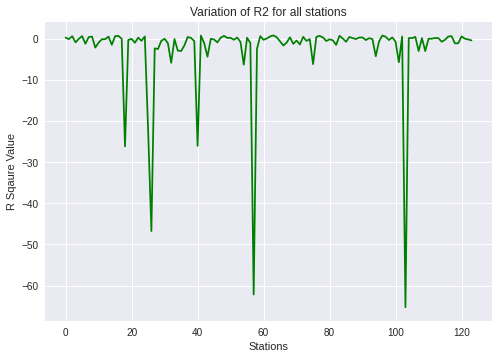

In [ ]:
plt.plot(range(124),metrics_df['R2'],color='green')
plt.title("Variation of R2 for all stations")
plt.xlabel("Stations")
plt.ylabel("R Sqaure Value")
plt.show()

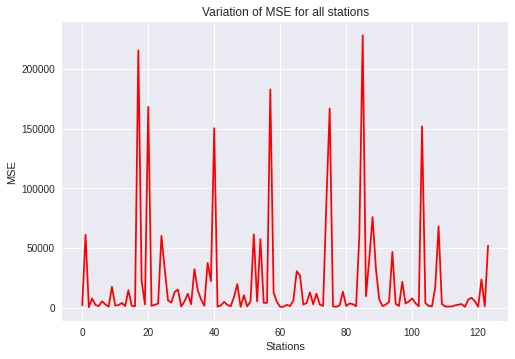

In [ ]:
plt.plot(range(124),metrics_df['MSE'],color='red')
plt.title("Variation of MSE for all stations")
plt.xlabel("Stations")
plt.ylabel("MSE")
plt.show()

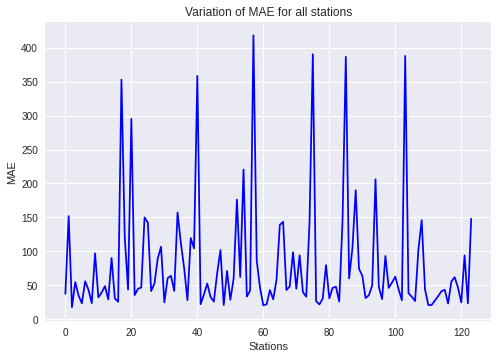

In [ ]:
plt.plot(range(124),metrics_df['MAE'],color='blue')
plt.title("Variation of MAE for all stations")
plt.xlabel("Stations")
plt.ylabel("MAE")
plt.show()

In [ ]:
srt = np.array(sorted(metrics_df['R2'].values))

In [ ]:
boolean = srt[srt > 0]

In [ ]:
boolean

array([0.00683193, 0.00706017, 0.01198983, 0.02274875, 0.0336344 ,
       0.06964711, 0.07585323, 0.15066582, 0.15575587, 0.1563199 ,
       0.17372753, 0.17428705, 0.18649211, 0.20154936, 0.21274957,
       0.22934859, 0.23473034, 0.25713876, 0.27088618, 0.27620717,
       0.29893615, 0.31549136, 0.31567854, 0.32151236, 0.32762977,
       0.34245285, 0.37108607, 0.3726554 , 0.41729825, 0.43910037,
       0.44879735, 0.45971011, 0.47265207, 0.4731748 , 0.5058746 ,
       0.53423152, 0.5413976 , 0.55883625, 0.57377259, 0.57792624,
       0.58763691, 0.58889644, 0.63566357, 0.6371661 , 0.64202538,
       0.65261121, 0.66379064, 0.71010913, 0.71270311, 0.71419566,
       0.73389045, 0.78971092, 0.80107925, 0.8241341 ])

In [ ]:
per_psve = len(boolean)/len(srt)
per_psve

0.43548387096774194

In [ ]:
latlong = pd.read_csv("drive/MyDrive/BTP/Graph/updated_latlong.csv")
latlong.head()

,Station,Latitude,Longitude
0,APSD Digras Yeotmal,20.093333,77.765833
1,ARS Achalpur Amravathi,21.304167,77.508889
2,ARS Buldhana Buldhana,20.536111,76.191111
3,ARS CHAS AHMEDNAGAR,19.037778,74.650000
4,ARS Eakarjuna Warora Chandrapur,20.216667,79.020556


In [ ]:
latlong_positive = latlong.iloc[presentation_df.index,0]

In [ ]:
latlong_positive.head()

0            APSD Digras Yeotmal
2          ARS Buldhana Buldhana
5        ARS Gadhinglaj Kolhapur
7               ARS Karad Satara
8    ARS Kutki Hinganghat Wardha
Name: Station, dtype: object

In [ ]:
presentation_df = metrics_df[metrics_df['R2'] > 0]
presentation_df.head()

,R2,MAE,MSE,Location
0,0.298936,37.372422,2149.238427,0
2,0.642025,17.698900,556.940527,2
5,0.663791,23.515923,1521.695511,5
7,0.417298,43.393671,2942.229650,7
8,0.541398,23.622222,1013.484510,8


In [ ]:
presentation_df

,R2,MAE,MSE,Location
0,0.298936,37.372422,2149.238427,0
2,0.642025,17.698900,556.940527,2
5,0.663791,23.515923,1521.695511,5
7,0.417298,43.393671,2942.229650,7
8,0.541398,23.622222,1013.484510,8
13,0.534232,29.188252,1455.498351,13
15,0.637166,30.520812,1753.911069,15
16,0.712703,25.695754,1360.706120,16
17,0.006832,353.022828,215371.261751,17
22,0.276207,44.782395,2518.412394,22


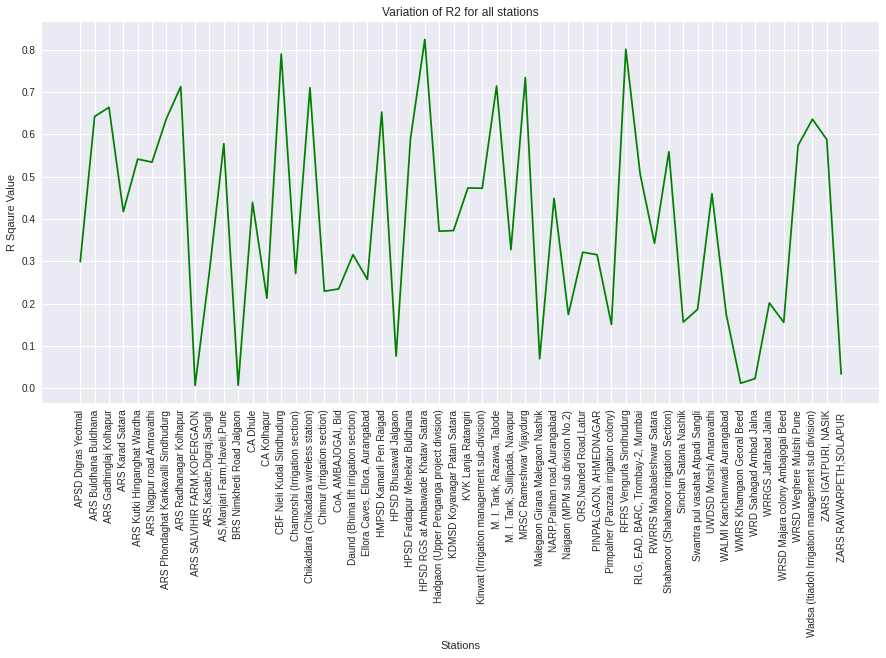

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(latlong_positive.values,presentation_df['R2'],color='green')
plt.title("Variation of R2 for all stations")
plt.xlabel("Stations")
plt.ylabel("R Sqaure Value")
plt.xticks(rotation=90)
plt.show()

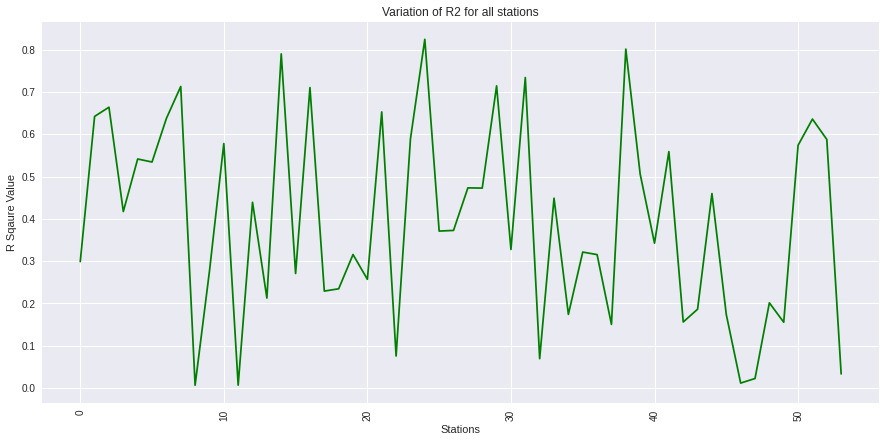

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(range(len(presentation_df['R2'])),presentation_df['R2'],color='green')
plt.title("Variation of R2 for all stations")
plt.xlabel("Stations")
plt.ylabel("R Sqaure Value")
plt.xticks(rotation=90)
plt.show()

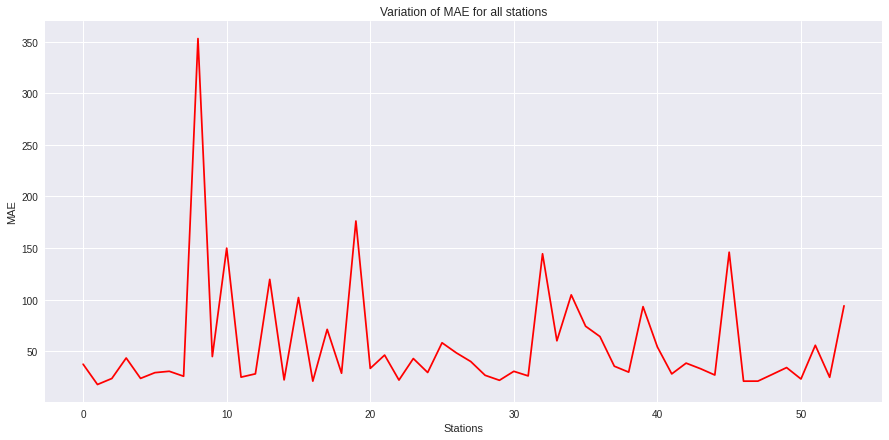

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(range(len(presentation_df['R2'])),presentation_df['MAE'],color='red')
plt.title("Variation of MAE for all stations")
plt.xlabel("Stations")
plt.ylabel("MAE")
# plt.xticks(rotation=90)
plt.show()

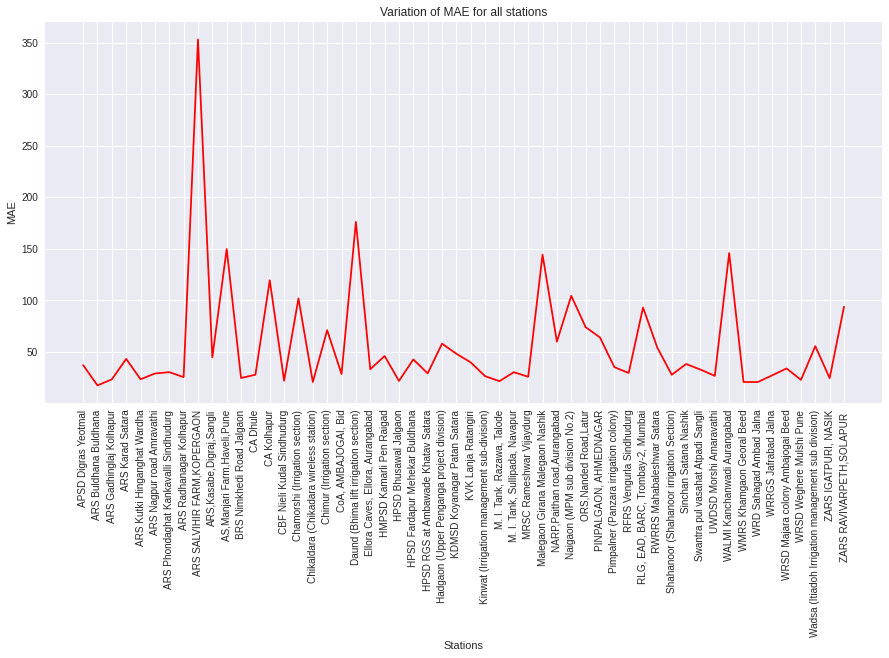

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(latlong_positive.values,presentation_df['MAE'],color='red')
plt.title("Variation of MAE for all stations")
plt.xlabel("Stations")
plt.ylabel("MAE")
plt.xticks(rotation=90)
plt.show()

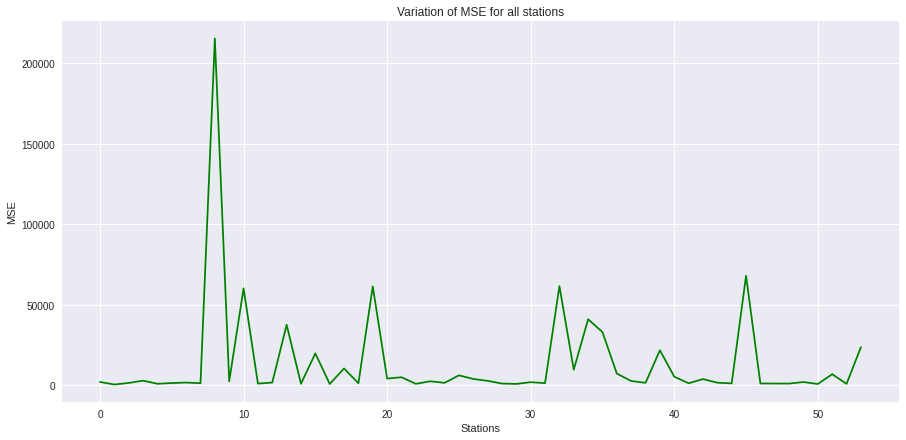

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(range(len(presentation_df['MSE'])),presentation_df['MSE'],color='green')
plt.title("Variation of MSE for all stations")
plt.xlabel("Stations")
plt.ylabel("MSE")
# plt.xticks(rotation=90)
plt.show()

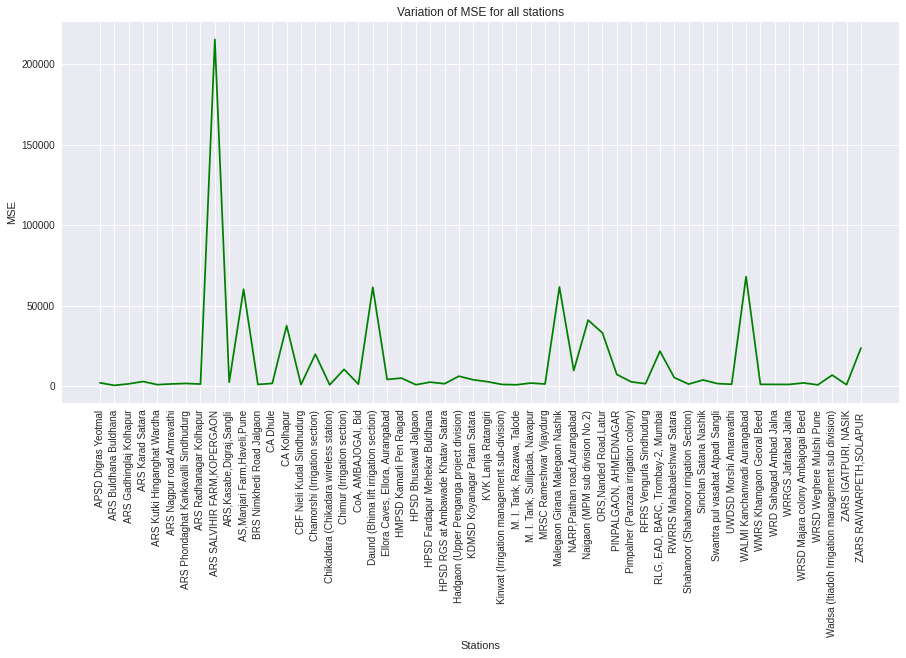

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(latlong_positive.values,presentation_df['MSE'],color='green')
plt.title("Variation of MSE for all stations")
plt.xlabel("Stations")
plt.ylabel("MSE")
plt.xticks(rotation=90)
plt.show()

Graph of the places with positive R2

In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 13.0MB/s 
     |████████████████████████████████| 14.8MB 218kB/s 
     |████████████████████████████████| 6.5MB 60.8MB/s 


In [ ]:
import descartes
import geopandas as gpd
from shapely.geometry import Point,Polygon
import folium

In [ ]:
maha_map = gpd.read_file('drive/MyDrive/BTP/maharashtra.geojson')
maha_map.head()

,cartodb_id,name_2,name_0,name_1,varname_2,nl_name_2,pop,id_2,type_2,id_0,id_1,iso,engtype_2,pop_prop_2011,geometry
0,1,Ahmednagar,India,Maharashtra,Ahmadnagar,None,4040642,306,District,105,21,IND,District,4.04,"MULTIPOLYGON (((74.49038 19.98079, 74.48566 19..."
1,3,Amravati,India,Maharashtra,"Amaravati, Amraoti, Amaraoti",None,2607160,308,District,105,21,IND,District,2.57,"MULTIPOLYGON (((77.47515 21.76574, 77.47551 21..."
2,5,Bhandara,India,Maharashtra,None,None,1136146,310,District,105,21,IND,District,1.07,"MULTIPOLYGON (((80.32510 21.49516, 80.32588 21..."
3,6,Bid,India,Maharashtra,Bir|Beed|Bhir|Bidh,None,2161250,311,District,105,21,IND,District,2.30,"MULTIPOLYGON (((75.49385 19.44063, 75.50288 19..."
4,9,Dhule,India,Maharashtra,"Dhulia, West Khandesh",None,1707947,314,District,105,21,IND,District,1.83,"MULTIPOLYGON (((74.87001 21.63029, 74.87106 21..."


In [ ]:
latlong_positive_all = latlong.iloc[presentation_df.index,:]

In [ ]:
geometry = [Point(xy) for xy in zip(latlong_positive_all["Longitude"],latlong_positive_all["Latitude"])]

In [ ]:
points = latlong_positive_all[['Latitude','Longitude']]

In [ ]:
from geopandas import GeoDataFrame

gdf = GeoDataFrame(points,geometry=geometry)

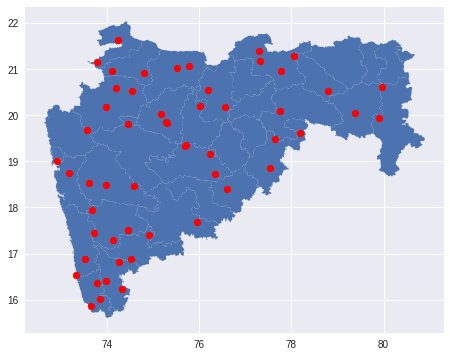

In [ ]:
gdf.plot(ax=maha_map.plot(figsize=(15,6)),marker='o',color='red')
# plt.savefig("Points_updated.png")

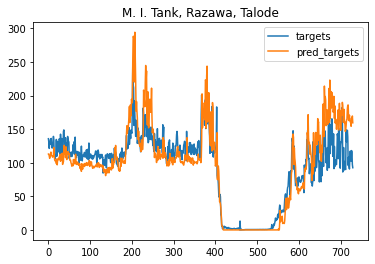

In [ ]:
plt.plot(range(len(values)),values,label="targets")
plt.plot(range(len(values)),pred_values,label="pred_targets")
plt.title("M. I. Tank, Razawa, Talode")
plt.legend()
plt.show()

In [ ]:
values = []
pred_values = []
for files in train_files:
  g, features, targets = load_data(file)
  values.append(targets[0][0])
  # net.train()
  pred = net(g.to(th.device('cuda:0')), features.cuda())
  pred_values.append(pred[0][0]) 

In [ ]:
def one_day_forecast(g, features):
  pred = net2(g.to(th.device('cuda:0')), features.cuda())
  new_features = th.zeros(features.size())
  print(features.size())
  print(new_features.size())
  # print(new_features)
  new_features[:,0:5,:] = features[:,1:6,:]
  new_features[:,5,:] = pred
  return pred, new_features

In [ ]:
def several_day_forecast(g, features, n_days):
  new_features = features
  for i in range(n_days):
    pred, new_features = one_day_forecast(g, new_features)
  return pred, new_features

In [ ]:
g, features, targets = load_data('2019-07-02.pkl')
pred, new_features = several_day_forecast(g, features, 7)

torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])
torch.Size([124, 6, 1])


In [ ]:
pred.shape

torch.Size([124, 1])

In [ ]:
new_features.shape

torch.Size([124, 6, 1])